In [1]:
# Change the path through the data 
falcon_path = "/home/chaputmarine/log/default/20210111_130809"

In [2]:
import yaml
import numpy as np
import glob
import os
import ast

# Utilities

In [3]:
def read_yaml_header( stream ):
    """Reads YAML header from stream.
    
    Parameters
    ----------
    stream : open file
    
    Returns
    -------
    header : YAML node
    headersize
    
    """
    
    s = stream.read(4)
    if (s.decode()!="---\n"):
        raise Exception("Invalid yaml header")
    
    header = ""
    s=b""
    while ( s.decode()!="...\n" ):
        header += s.decode()
        s = stream.readline()
    return yaml.safe_load(header), stream.tell()


def data_description_to_dtype( desc ):
    """Converts data description string to numpy stype.
    
    Parameters
    ----------
    desc : string
    
    Returns
    -------
    dtype
    
    """
    
    dt = []
    
    for field in desc:
        
        parts = field.split(" ")
        
        if len(parts)!=3:
            raise Exception("Invalid field description")
        
        if parts[1]=='string': parts[1]='str'
        
        parts[2] = parts[2].replace('[','(').replace(']',')')
        dt.append( (parts[0], (getattr(np,parts[1]),ast.literal_eval(parts[2]))) )
    return np.dtype( dt )


def load_file( filename ):
    """Loads data from serialized Falcon data file.
    
    Parameters
    ----------
    filename : string
    
    Returns
    -------
    data : YAML node or numpy array;
    
    header : YAML node
    
    """
    
    with open( filename, 'rb' ) as fid:
        
        #load header
        header, headersize = read_yaml_header( fid )
        
        if header["encoding"]=="BINARY":
            dt = data_description_to_dtype( header["data"] )
            data = np.memmap( filename, dtype=dt, mode='r', offset=headersize )
        elif header["encoding"]=="YAML":
            data = yaml.safe_load( fid )
        else:
            raise Exception("Unknown encoding")
        
    return data, header

def read_yaml_data(data):
    hdw = []
    src = []
    for packet in data:
        hdw.append([packet["data"]["hardware_ts"], packet["data"]["event"]])
        src.append([packet["data"]["source_ts"], packet["data"]["event"]])
    return np.array(hdw), np.array(src)



def update_prop(handle, orig):
    handle.update_from(orig)
    x,y = handle.get_data()
    handle.set_data([np.mean(x)]*2, [0, 2*y[0]])


# Load data

### Data

In [4]:
source, header= load_file(os.path.join(falcon_path, "datasink-source/datasink-source.0_source.hp.0.bin"))
print(header)

{'creator': 'datasink-source', 'date': datetime.datetime(2021, 1, 11, 13, 8, 9), 'version': 1, 'interleaved': False, 'format': 'FULL', 'encoding': 'BINARY', 'stream': 0, 'data': ['stream uint16 (1)', 'packet uint64 (1)', 'source_ts uint64 (1)', 'hardware_ts uint64 (1)', 'serial_number uint64 (1)', 'timestamps uint64 (1)', 'signal float64 (2,1)']}


/home/chaputmarine/miniconda3/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [5]:
filt, header= load_file(glob.glob(os.path.join(falcon_path, "detector-sink/*"))[0])
print(header)

filt_out, header= load_file(glob.glob(os.path.join(falcon_path, "detector-sink-out/*"))[0])
print(header)

detector, header= load_file(os.path.join(falcon_path, "datasink-detector/datasink-detector.0_HIPPOCAMPUS-detector.statistics.0.bin"))
print(header)


{'creator': 'detector-sink', 'date': datetime.datetime(2021, 1, 11, 13, 8, 9), 'version': 1, 'interleaved': False, 'format': 'FULL', 'encoding': 'BINARY', 'stream': 0, 'data': ['stream uint16 (1)', 'packet uint64 (1)', 'source_ts uint64 (1)', 'hardware_ts uint64 (1)', 'serial_number uint64 (1)', 'timestamps uint64 (1)', 'signal float64 (2,1)']}
{'creator': 'detector-sink-out', 'date': datetime.datetime(2021, 1, 11, 13, 8, 9), 'version': 1, 'interleaved': False, 'format': 'FULL', 'encoding': 'BINARY', 'stream': 0, 'data': ['stream uint16 (1)', 'packet uint64 (1)', 'source_ts uint64 (1)', 'hardware_ts uint64 (1)', 'serial_number uint64 (1)', 'timestamps uint64 (1)', 'signal float64 (1,1)']}
{'creator': 'datasink-detector', 'date': datetime.datetime(2021, 1, 11, 13, 8, 9), 'version': 1, 'interleaved': False, 'format': 'COMPACT', 'encoding': 'BINARY', 'stream': 0, 'data': ['timestamps uint64 (1)', 'signal float64 (2)']}


/home/chaputmarine/miniconda3/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [6]:
# Read event data
event, header= load_file(glob.glob(os.path.join(falcon_path, "datasink-ev/*"))[0])
event_hdw, event_src = read_yaml_data(event) 

# Read event data
event, header= load_file(glob.glob(os.path.join(falcon_path, "datasink-out-ev/*"))[0])
event_out_hdw, event_out_src = read_yaml_data(event) 

In [7]:
# Stimulation output
stim, header= load_file(glob.glob(os.path.join(falcon_path, "datasink-stimulation/*"))[0])
stim_hdw, stim_src = read_yaml_data(stim)

print(header)

{'creator': 'datasink-stimulation', 'date': datetime.datetime(2021, 1, 11, 13, 8, 9), 'version': 1, 'interleaved': False, 'format': 'FULL', 'encoding': 'YAML', 'stream': 0, 'data': ['stream uint16 (1)', 'packet uint64 (1)', 'source_ts uint64 (1)', 'hardware_ts uint64 (1)', 'serial_number uint64 (1)', 'event_string str (128)']}


## Source step

Text(0.5, 1.0, 'Source step - Signal generated by Neuralynx testbench.')

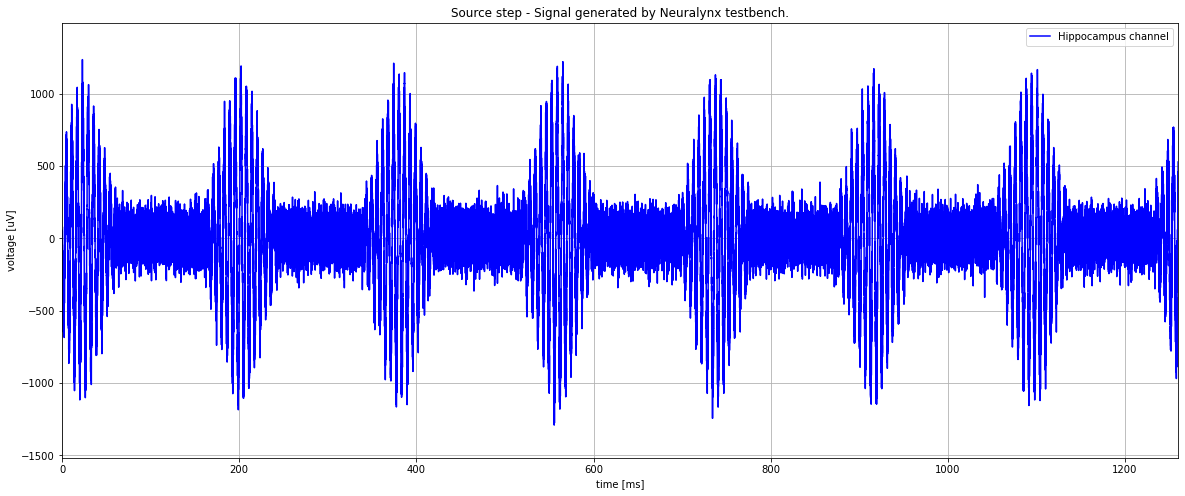

In [9]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (20,8))

start_time = (float(event_out_hdw[0][0]))/1e3  - 80
end_time = start_time + 180*7
        
ax.plot((source['timestamps'][:])/1e3-start_time, source['signal'][:,1], color='blue', label="Hippocampus channel") 

ax.set_xlim([0, end_time-start_time ])
ax.set_xlabel("time [ms]")
ax.grid(which='major', linestyle='-')
ax.set_ylabel("voltage [uV]")
ax.legend()
ax.set_title("Source step - Signal generated by Neuralynx testbench.")

## Filtering Step

Text(0.5, 1.0, 'Artefact removal step')

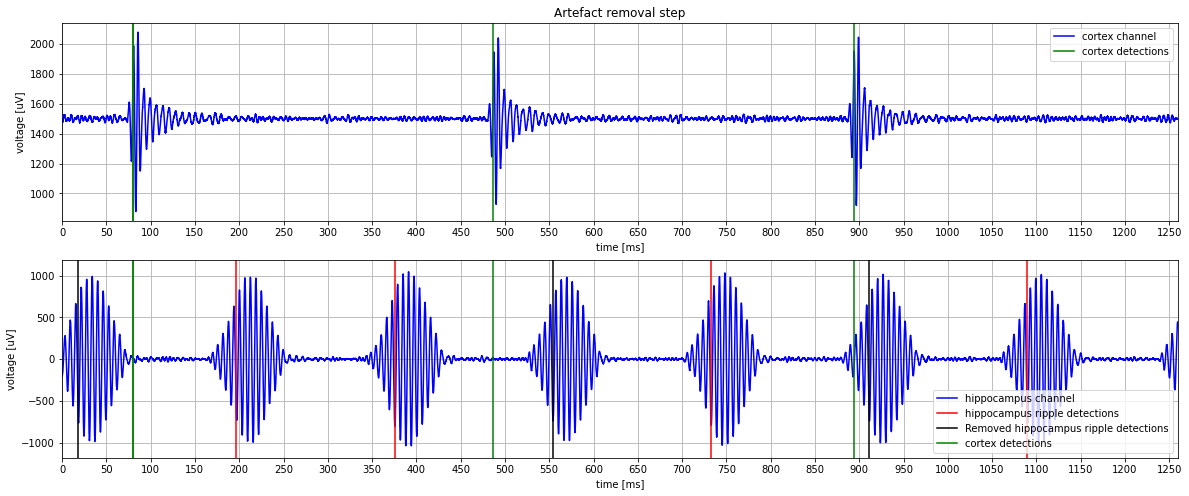

In [29]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots(2,1, figsize = (20,8))

axis[1].plot((filt['timestamps'][:])/1e3-start_time, filt['signal'][:, 0, 0], color='blue', label='hippocampus channel') 
axis[0].plot((filt_out['timestamps'][:])/1e3-start_time, filt_out['signal'][:, 0, 0]+1500, color='blue', label='cortex channel') 


axis[1].axvline(x=float(event_hdw[7][0])/1e3-start_time, color="red", label="hippocampus ripple detections")
axis[1].axvline(x=float(event_hdw[6][0])/1e3-start_time, color="black", label="Removed hippocampus ripple detections")

axis[1].axvline(x=float(event_out_hdw[0][0])/1e3-start_time, color="green",label="cortex detections")

axis[0].axvline(x=float(event_out_hdw[0][0])/1e3-start_time, color="green",label="cortex detections")

for i, xc in enumerate(event_hdw):
    if i > 7:
        if i%2:
            axis[1].axvline(x=float(xc[0])/1e3-start_time, color="black")
        else:
            axis[1].axvline(x=float(xc[0])/1e3-start_time, color="red")

for xc in event_out_hdw:
    axis[0].axvline(x=float(xc[0])/1e3-start_time, color="green")
    axis[1].axvline(x=float(xc[0])/1e3-start_time, color="green")

for ax in axis:
    
    ax.set_xticks(np.arange(0, end_time-start_time, step=50))
    ax.set_xlim([0, end_time-start_time ])
    ax.set_xlabel("time [ms]")
    ax.grid(which='major', linestyle='-')
    ax.set_ylabel("voltage [uV]")
    ax.legend()

axis[0].set_title("Artefact removal step")

Text(0.5, 1.0, 'Filtering step')

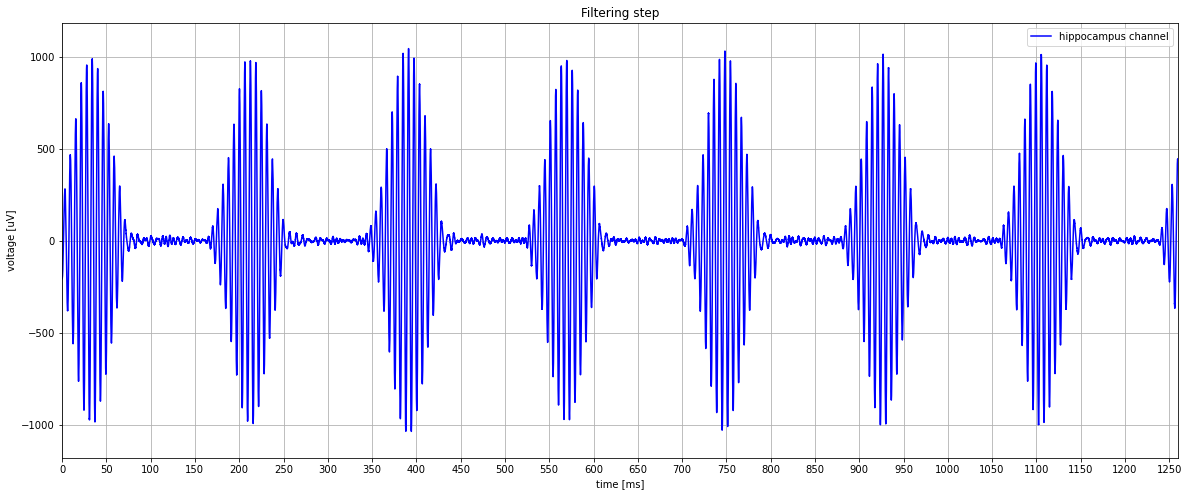

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (20,8))

ax.plot((filt['timestamps'][:])/1e3-start_time, filt['signal'][:, 0, 0], color='blue', label='hippocampus channel') 



ax.set_xticks(np.arange(0, end_time-start_time, step=50))
ax.set_xlim([0, end_time-start_time ])
ax.set_xlabel("time [ms]")
ax.grid(which='major', linestyle='-')
ax.set_ylabel("voltage [uV]")
ax.legend()
ax.set_title("Filtering step")

## Detector step

In [14]:
ts = []
th = []
signal =[]
for i in range(len(detector)):
    ts.append(detector[i][0]/1e3-start_time)
    th.append(detector[i][1][1])
    signal.append(detector[i][1][0])

Text(0.5, 1.0, 'Ripple detection step.')

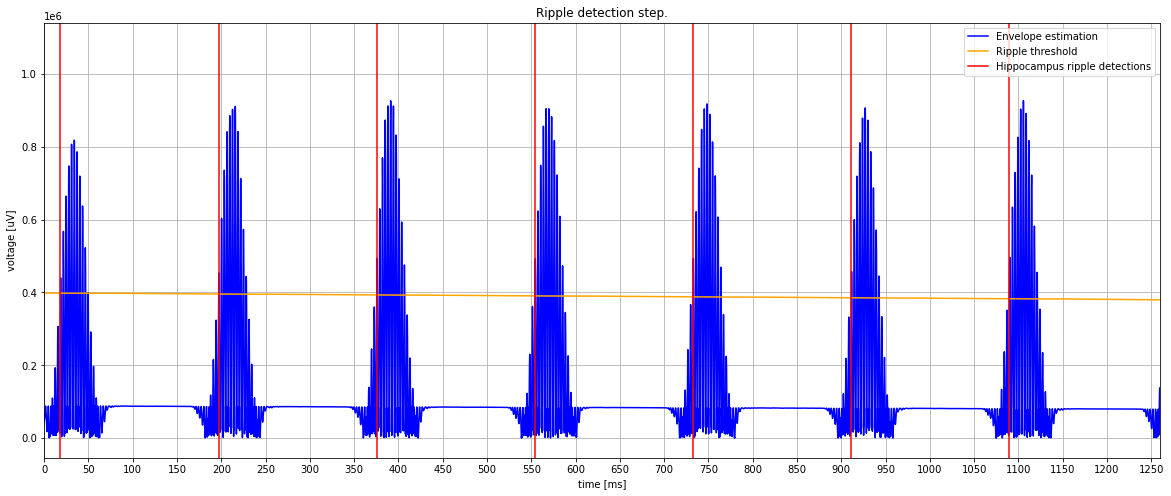

In [32]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (20,8))

s1 = ax.plot(ts, signal, color='blue', label = "Envelope estimation" ) 
s2 = ax.plot(ts, th, color='orange', label ="Ripple threshold" ) 

rp = ax.axvline(x=float(event_hdw[0][0])/1e3-start_time, color="red", label="Hippocampus ripple detections")
for xc in event_hdw:
    rp = ax.axvline(x=float(xc[0])/1e3-start_time, color="red")
    
        
ax.set_xticks(np.arange(0, end_time-start_time, step=50))
ax.set_xlim([0, end_time-start_time ])
ax.set_xlabel("time [ms]")
ax.grid(which='major', linestyle='-')
ax.set_ylabel("voltage [uV]")

ax.legend()
ax.set_title("Ripple detection step.")
